# Load libraries and data

In [23]:
library(tidyverse)
library(caret)
library(factoextra)
library(class)

In [2]:
# Training paths
a_train_path = "/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Sensor Classification Project/Dataset/all_raw_data_a_train.csv"
g_train_path = "/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Sensor Classification Project/Dataset/all_raw_data_g_train.csv"
a_test_path = "/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Sensor Classification Project/Dataset/all_raw_data_a_test.csv"
g_test_path = "/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Sensor Classification Project/Dataset/all_raw_data_g_test.csv"

# Training data
data_a_train = read.csv(a_train_path, encoding = "UTF-8")
data_g_train = read.csv(g_train_path, encoding = "UTF-8")

# Testing data
data_a_test = read.csv(a_test_path, encoding = "UTF-8")
data_g_test = read.csv(g_test_path, encoding = "UTF-8")

# Data processing

### 1. Join a_train and g_train

In [3]:
data = merge(data_a_train, data_g_train,
                     by = c("user_id","exp_id","epoch"))

test_data = merge(data_a_test, data_g_test,
                     by = c("user_id", "exp_id", "epoch"))

### 2. Deal with missing data

In [4]:
data = na.omit(data)

Only 1 missing datapoint removed.

### 3. Select relevant features

In [5]:
data = 
    data %>%
    select(user_id:AR12.1.x,
           m1.y:AR12.1.y) %>%
    rename(activity = activity.x,
           sample = sample.x)

test_data = 
    test_data %>%
    select(user_id:AR12.1.x,
           m1.y:AR12.1.y) %>%
    rename(activity = activity.x,
           sample = sample.x)

### 4. Change data structure

In [6]:
data$activity = as.character(data$activity)
test_data$activity = as.character(test_data$activity)

In [7]:
test_data$activity = NA

# Modelling

1. KNN with PCA
2. Multinomial one-vs-all regression
3. LDA with data transformation
4. QDA with data transformation

### 1. KNN with PCA

#### Set aside unncessary columns

In [8]:
# Get unnecessary sections for train/test
KNN_unnecessary = 
    data %>%
    select(user_id:epoch,
           sample)

KNN_unnecessary_test = 
    test_data %>%
    select(user_id:epoch,
           sample)

# Get necessary sections for train/test
KNN_train = 
    data %>%
    select(-user_id:-epoch,
           -sample)

KNN_test = 
    test_data %>%
    select(-user_id:-epoch,
           -sample)

joined = rbind(KNN_train, KNN_test)

#### Get principle components

In [9]:
# PCA data 
PCA_data = 
    joined %>%
    select(-activity)

# PCA fitted
PCA_fitted = prcomp(PCA_data, scale = TRUE)

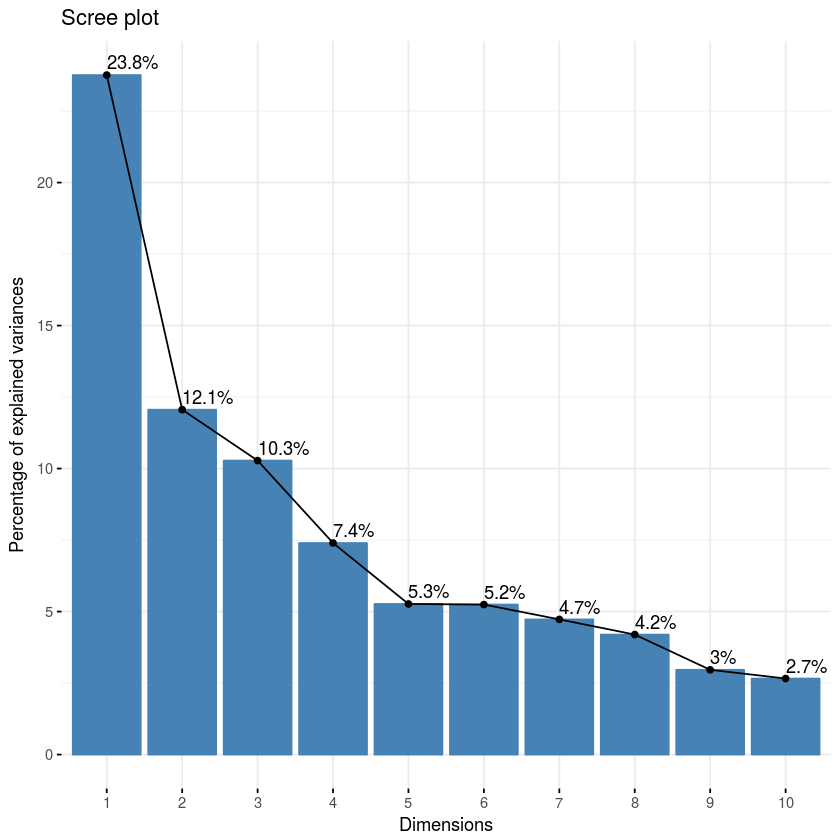

In [10]:
fviz_eig(PCA_fitted, addlabels = TRUE)

Use 5 components - roughly accounts for 60% of the variance of the data.

In [45]:
PCA_scores = as.data.frame(cbind(joined[,1], PCA_fitted$x[,1:5]))
PCA_scores = 
    PCA_scores %>%
    rename(activity = V1)

In [46]:
# Training data
KNN_train =
    PCA_scores %>%
    filter(!is.na(activity)) 

# Test data
KNN_test = 
    PCA_scores %>%
    filter(is.na(activity))

#### Running KNN with 5 principle components

In [47]:
model1 =
    knn(train=KNN_train[-1], test=KNN_test[-1],
        cl=KNN_train$activity, k=7)

In [48]:
KNN_test$activity = model1

KNN_test = cbind(KNN_test, KNN_unnecessary_test)

In [51]:
KNN_test %>%
  mutate(user_id = paste("user", user_id, sep=""), exp_id = paste("exp", exp_id, sep="")) %>%
  unite(Id, user_id, exp_id, sample) %>%
  select(Id, Predicted = activity) %>%
  mutate(Predicted = Predicted) %>%
  write.csv("test_set_predictions_k7.csv",fileEncoding = "UTF-8", row.names = F)